In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.datasets import load_diabetes

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

In [2]:
def get_bs_theta(X, y, N):
    theta_bs = []

    for _ in range(N):
        X_boot, y_boot = get_bootstrap_sample(X, y)

        model = LinearRegression()
        model.fit(X_boot, y_boot)

        theta_bs.append([model.intercept_] + list(model.coef_))

    return np.array(theta_bs)


def get_bootstrap_sample(X, y):
    bootstrap_inds = np.random.choice(len(y), size=len(y), replace=True)
    return X[bootstrap_inds], y[bootstrap_inds]

In [3]:
def reduce(inputs):
    res = 0
    for inp in inputs:
        res += inp
    return res / len(inputs)


def linear_model(theta, X):
    return X @ theta[1:] + theta[0]

In [4]:
def train_model(
        X,
        y,
        amortized_bootstrap, 
        model, 
        optimizer, 
        criterion, 
        T, 
        k, 
        latent_size,
        gradient_steps
    ):

    history = []
    for _ in tqdm(range(T)):
        bootstrap_samples = [get_bootstrap_sample(X, y) for _ in range(k)]
        
        X_k, y_k = zip(*bootstrap_samples)

        z_k = [torch.randn(latent_size) for _ in range(k)] 

        epoch_loss = []
        for _ in range(gradient_steps):
            theta_k = [amortized_bootstrap(z) for z in z_k] 

            y_pred_k = [model(theta_cur, X_cur) for theta_cur, X_cur in zip(theta_k, X_k)]

            loss_k = [criterion(y_pred, y) for y_pred, y in zip(y_pred_k, y_k)]
            loss = reduce(loss_k)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

        history.append(np.mean(epoch_loss))

    return history

# Diabetes

In [5]:
diabetes_data = load_diabetes(as_frame=True)

X = diabetes_data['data'][['bmi', 'bp']].values
y = diabetes_data['target'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
theta_bs = get_bs_theta(X_train, y_train, 1000)

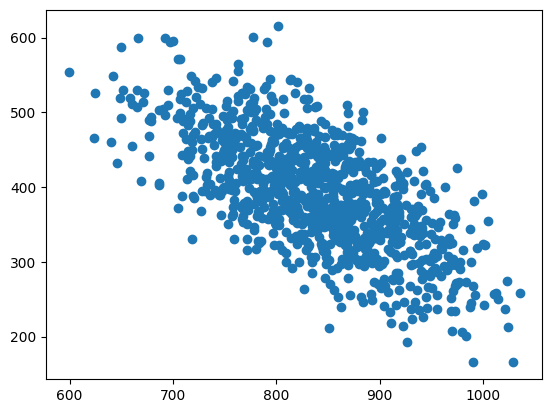

In [8]:
plt.scatter(theta_bs[:, 1], theta_bs[:, 2])

In [9]:
X_train_tensor, X_test_tensor = torch.FloatTensor(X_train), torch.FloatTensor(X_test)
y_train_tensor, y_test_tensor = torch.FloatTensor(y_train), torch.FloatTensor(y_test)

In [73]:
amortized_bootstrap = nn.Sequential(
    nn.Linear(25, 50),
    nn.ReLU(),
    nn.Linear(50, 3)
)

In [104]:
class BootstrapLinreg():
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def sample(self, k=1):
        return get_bs_theta(self.X, self.y, k)

class AmortizedBootstrapLinreg():
    def __init__(self, generator):
        self.generator = generator
        self.latent_size = generator[0].in_features

    def sample(self, k=1):
        z = torch.randn((k, self.latent_size))
        theta_pred = self.generator(z).detach().numpy()
        return theta_pred

In [105]:
bs_linreg = BootstrapLinreg(X_train, y_train)
am_bs_linreg = AmortizedBootstrapLinreg(amortized_bootstrap)

In [74]:
optimizer = torch.optim.Adam(amortized_bootstrap.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = train_model(X_train_tensor, y_train_tensor, amortized_bootstrap, linear_model, optimizer, criterion, 2000, 3, 25, 100)

100%|██████████| 2000/2000 [02:29<00:00, 13.34it/s]


Text(0, 0.5, 'Loss')

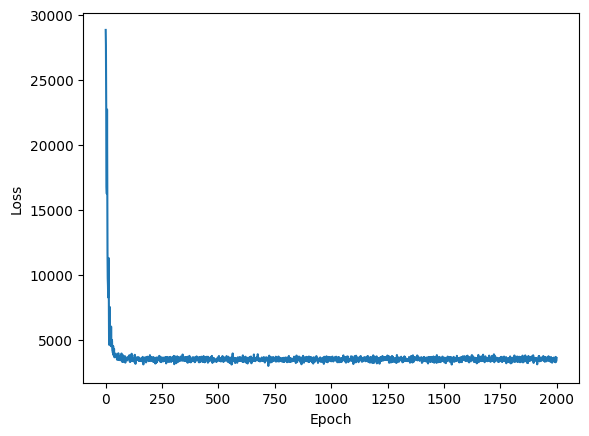

In [75]:
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [106]:
z = torch.randn((1000, 25))

theta_pred = amortized_bootstrap(z).detach().numpy()

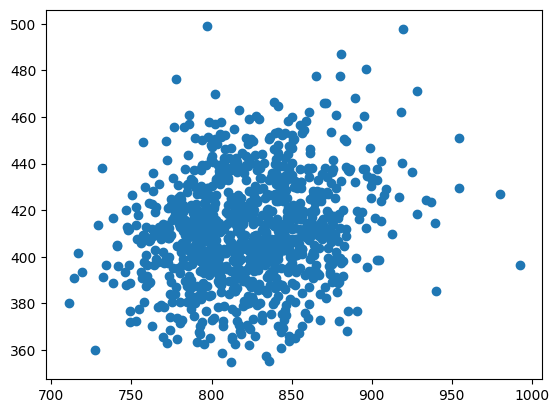

In [107]:
plt.scatter(theta_pred[:, 1], theta_pred[:, 2])

In [122]:
def eval_bagging(sampler, model, X, y, k_list, n_rerun=100):
    mse_list = []

    for k in k_list:
        mse_cur = []
        for _ in range(n_rerun):
            theta_sampled = sampler.sample(k)
            y_pred = np.array([model(theta_sampled[i], X) for i in range(k)]).mean(axis=0)
        
            mse_cur.append(mean_squared_error(y, y_pred))
        
        mse_list.append(mse_cur)

    return np.array(mse_list)

In [125]:
k_list = list(range(1, 26))

mse_bs = eval_bagging(bs_linreg, linear_model, X_test, y_test, k_list)
mse_ambs = eval_bagging(am_bs_linreg, linear_model, X_test, y_test, k_list)

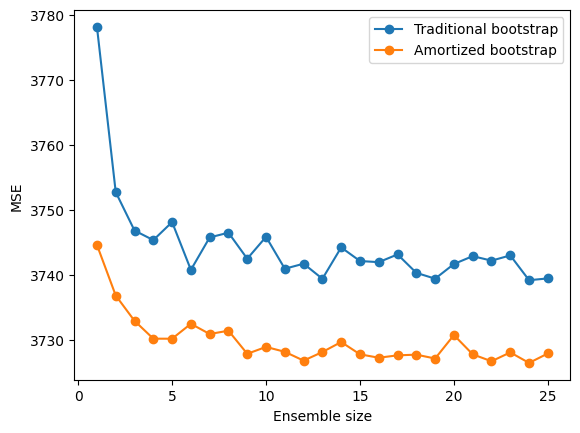

In [131]:
plt.plot(k_list, mse_bs.mean(axis=1), label='Traditional bootstrap', marker='o')
plt.plot(k_list, mse_ambs.mean(axis=1), label='Amortized bootstrap', marker='o')
plt.xlabel('Ensemble size')
plt.ylabel('MSE')
plt.legend()

# Cover type

In [48]:
pd.read_csv('data/covertype_csv.csv')

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366,...,0,0,0,0,0,0,0,0,0,5
1,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838,...,0,0,0,0,0,0,0,0,0,5
2,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339,...,0,0,0,0,0,0,0,0,0,2
3,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886,...,0,0,0,0,0,0,0,0,0,2
4,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,0.268634,0.425000,0.303030,0.060845,0.245478,0.015175,0.944882,0.933071,0.464567,0.116688,...,0,0,0,0,0,0,0,0,0,3
581008,0.266133,0.422222,0.287879,0.047960,0.239018,0.013348,0.944882,0.933071,0.468504,0.117803,...,0,0,0,0,0,0,0,0,0,3
581009,0.263632,0.441667,0.257576,0.042949,0.232558,0.012646,0.929134,0.948819,0.511811,0.119058,...,0,0,0,0,0,0,0,0,0,3
581010,0.262631,0.472222,0.227273,0.042949,0.229974,0.012646,0.905512,0.964567,0.562992,0.120452,...,0,0,0,0,0,0,0,0,0,3


# Boston

In [132]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [133]:
X = data[:, [0, 5]]
y = target

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
theta_bs = get_bs_theta(X_train, y_train, 1000)

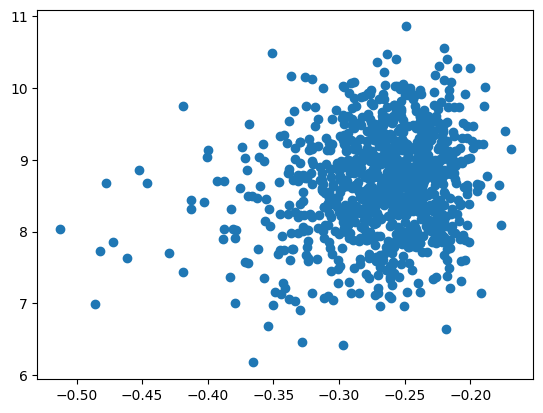

In [136]:
plt.scatter(theta_bs[:, 1], theta_bs[:, 2])

In [137]:
X_train_tensor, X_test_tensor = torch.FloatTensor(X_train), torch.FloatTensor(X_test)
y_train_tensor, y_test_tensor = torch.FloatTensor(y_train), torch.FloatTensor(y_test)

In [154]:
amortized_bootstrap = nn.Sequential(
    nn.Linear(25, 50),
    nn.ReLU(),
    nn.Linear(50, 3)
)

In [155]:
optimizer = torch.optim.Adam(amortized_bootstrap.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = train_model(X_train_tensor, y_train_tensor, amortized_bootstrap, linear_model, optimizer, criterion, 2000, 3, 25, 25)

100%|██████████| 2000/2000 [02:12<00:00, 15.11it/s]


In [156]:
bs_linreg = BootstrapLinreg(X_train, y_train)
am_bs_linreg = AmortizedBootstrapLinreg(amortized_bootstrap)

In [157]:
theta_pred = am_bs_linreg.sample(1000)

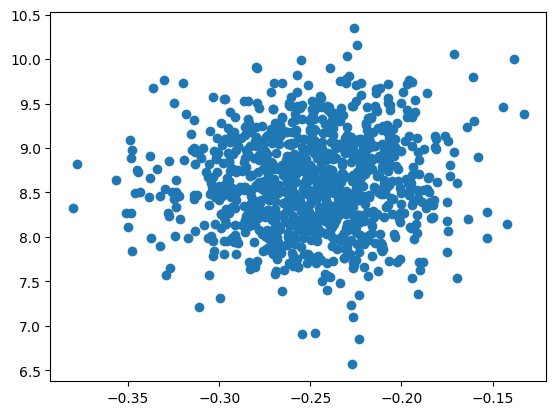

In [158]:
plt.scatter(theta_pred[:, 1], theta_pred[:, 2])

In [161]:
k_list = list(range(1, 26))

mse_bs = eval_bagging(bs_linreg, linear_model, X_test, y_test, k_list)
mse_ambs = eval_bagging(am_bs_linreg, linear_model, X_test, y_test, k_list)

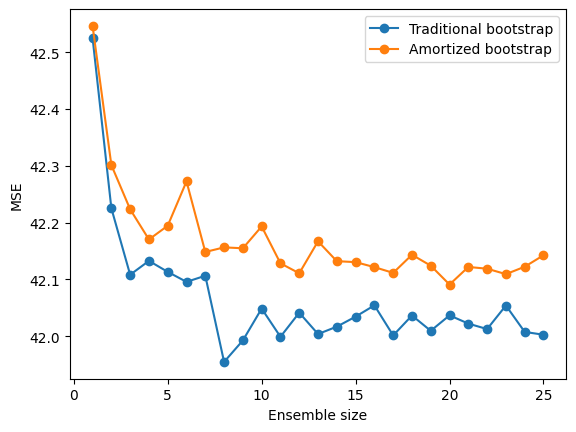

In [162]:
plt.plot(k_list, mse_bs.mean(axis=1), label='Traditional bootstrap', marker='o')
plt.plot(k_list, mse_ambs.mean(axis=1), label='Amortized bootstrap', marker='o')
plt.xlabel('Ensemble size')
plt.ylabel('MSE')
plt.legend()